# effiency of $CC1p$ events

In [1]:
from Xsec_setup import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/Xsec/Figures/efficiencies/'

In [3]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
selected_path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = selected_path + versions['Overlay'] + '_' + versions['overlay date'] + '_'
selected_overlay=dict()

cuts_order  = ['no cut','Chi2Proton','Nflashes','MatchedFlash','length'
               ,'non-collinearity','vertex activity'
               ,'delta phi','Pt & delta phi']
cutlabels = ['preselection','$dE/dx$ profile',r'$N_{flashes}>0$','optical filter','track lengths'
             ,'non-collinearity','vertex activity'
             ,'coplanarity','$p_t<0.35$ GeV/c']

if os.path.isfile(prefix+'selected_cosmic.csv'): 
    print 'checked',prefix+'selected_cosmic.csv','and found the file...'
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')

else:
    print 'checked',prefix+'selected_cosmic.csv','and there was no file there...'
    OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
        outcsvname = prefix+'selected_'+pair_type+'.csv'
        selected_overlay[pair_type].to_csv(outcsvname)
        print 'saved selected',pair_type,'to',outcsvname
    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    print "Nevents['f(POT)']:",Nevents['f(POT)']

selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(selected_overlay_concat),'events in the overlay'

checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_cosmic.csv and found the file...
13551 events in the overlay


In [4]:
genie = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/genie/'
                    +versions['overlay date']+'/'
                    +versions['Overlay']+'_'+versions['overlay date']+'_genie.csv')
print len(genie),'events in genie'

930168 events in genie


In [5]:
genie_CC1p = genie[(genie.IsCC_1p_200MeVc==True) & (genie.IsInActiveVolume==True)]
selected_CC1p = selected_overlay['CC 1p']
print len(selected_CC1p),'selected CC1p events overlay'
print len(genie_CC1p),'CC1p events in genie'

10877 selected CC1p events overlay
123360 CC1p events in genie


## absolute efficiency

In [6]:
def get_eff(Ngen=1,Nsel=1,debug=0):
    '''
    return: eff, eff_err    
    '''
    eff = float(Nsel)/Ngen
    eff_err = eff*np.sqrt(1./Nsel + 1./Ngen)
    if debug: print 'eff = %.4f +/ %.4f'%(eff,eff_err)
    return eff,eff_err

def get_eff_samples(generated=None,selected=None,debug=0):
    '''
    return: eff, eff_err    
    '''
    Ngen = float(len(generated))
    Nsel = float(len(selected))
    return get_eff(Ngen=Ngen,Nsel=Nsel,debug=debug)

In [7]:
get_eff_samples(generated=genie_CC1p,selected=selected_CC1p)

(0.08817282749675746, 0.0008819198995310177)

### 1d efficiency distribution

In [8]:
bins=Bins['Pmu']
xvar='truth_Pmu'
xlabel=Labels['Pmu']
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
h = dict()
h['generated'],_ = np.histogram(genie_CC1p[xvar],bins=bins)
h['selected'],_ = np.histogram(selected_CC1p[xvar],bins=bins)

h['eff'],h['eff err'] = [],[]
for i in range(len(bins)-1):
    print i,bins[i]
    eff,eff_err = get_eff(Ngen=h['generated'][i],Nsel=h['selected'][i])
    h['eff'].append(eff)
    h['eff err'].append(eff_err)
print 'done.'

0 0.1
1 0.333333333333
2 0.566666666667
3 0.8
4 1.03333333333
5 1.26666666667
done.


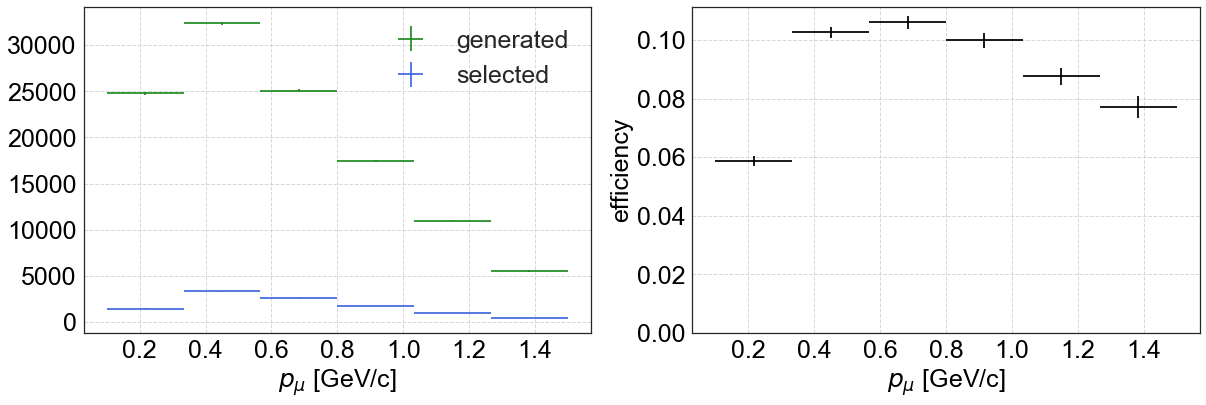

In [9]:
fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(1,2,1)
for label,color in zip(['generated','selected'],['forestgreen','royalblue']):
    plt.errorbar(x=mid,xerr=bin_width,y=h[label],yerr=np.sqrt(h[label])
                 ,color=color,capsize=10,fmt='.',markersize=0,label=label)
set_axes(ax,xlabel,do_add_grid=True,do_add_legend=True)

ax=fig.add_subplot(1,2,2)
plt.errorbar(x=mid,xerr=bin_width,y=h['eff'],yerr=h['eff err']
                 ,color='black',capsize=10,fmt='.',markersize=0)
set_axes(ax,xlabel,y_label='efficiency',do_add_grid=True,ylim=(0,1.05*np.max(h['eff']+h['eff err'])))

## smear the generated observables

In [10]:
migration_maps_path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/migration_maps/'

In [11]:
filename = migration_maps_path + "%s_vs_%s_%d_bins.csv"%('truth_Pmu','reco_Pmu_mcs',len(Bins['Pmu'])-1)
migration_map_Pmu = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pmu \n',migration_map_Pmu
filename = migration_maps_path + "%s_vs_%s_%d_bins.csv"%('truth_Pmu_theta','reco_Pmu_mcs_theta',len(Bins['theta(mu)'])-1)
migration_map_Pmu_theta = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pmu_theta \n',migration_map_Pmu_theta
filename = migration_maps_path + "%s_vs_%s_%d_bins.csv"%('truth_Pp','reco_Pp',len(Bins['Pp'])-1)
migration_map_Pp = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pp \n',migration_map_Pp
filename = migration_maps_path + "%s_vs_%s_%d_bins.csv"%('truth_Pp_theta','reco_Pp_theta',len(Bins['theta(p)'])-1)
migration_map_Pp_theta = np.loadtxt(filename,delimiter=',')
print 'migration_map_Pp_theta \n',migration_map_Pp_theta

# fig,ax = plt.subplots(figsize=(9.708,6))
# sns.set(font_scale=2);
# sns.heatmap(migration_map,annot=True,fmt=".2f",cbar=False,cmap='jet')
# set_axes(ax,'True bin $j$','Reconstructed bin $i$')
# ax.invert_yaxis()
# plt.tight_layout()

IOError: [Errno 2] No such file or directory: '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/migration_maps/truth_Pmu_vs_reco_Pmu_mcs_6_bins.csv'

In [ ]:
def find_bin( x , bins ):    
    for i in range(len(bins)-1):
        if bins[i]<x and x<bins[i+1]:
            return i
    return 0

In [ ]:
debug=0
smeared_Pmu_array,smeared_Pmu_theta_array,smeared_Pp_array,smeared_Pp_theta_array = [],[],[],[]
for i,row in selected_CC1p.iterrows():
    
    # smearing p(muon)
    true_bin_j = find_bin(row['truth_Pmu'], Bins['Pmu'])
    smeared_Pmu_array.append(choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,true_bin_j]))

    # smearing theta(muon)
    true_bin_j = find_bin(180./np.pi*row['truth_Pmu_theta'], Bins['theta(mu)'])
    smeared_Pmu_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(mu)'][1:]+Bins['theta(mu)'][:-1]) , p=migration_map[:,true_bin_j]))

    # smearing p(proton)
    true_bin_j = find_bin(row['truth_Pp'], Bins['Pp'])
    smeared_Pp_array.append(choice(a=0.5*(Bins['Pp'][1:]+Bins['Pp'][:-1]) , p=migration_map[:,true_bin_j]))

    # smearing theta(proton)
    true_bin_j = find_bin(180./np.pi*row['truth_Pp_theta'], Bins['theta(p)'])
    smeared_Pp_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j]))

    
    if debug:
        print 'truth_Pmu:',row['truth_Pmu']
        print 'smeared_Pmu:',choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,find_bin(row['truth_Pmu'], Bins['Pmu'])])        
        print 'truth_Pp_theta:',row['truth_Pp_theta']
        print 'true_bin_j:',true_bin_j
        print 'smeared_Pp_theta:',choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print 'smeared_Pp_theta:',np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print_line()
        
print 'done looping.'
selected_CC1p['smeared_Pmu']=smeared_Pmu_array
selected_CC1p['smeared_Pmu_theta']=smeared_Pmu_theta_array
selected_CC1p['smeared_Pp']=smeared_Pp_array
selected_CC1p['smeared_Pp_theta']=smeared_Pp_theta_array
print 'done smearing selected CC 1p'

In [ ]:
debug=0
smeared_Pmu_array,smeared_Pmu_theta_array,smeared_Pp_array,smeared_Pp_theta_array = [],[],[],[]
for i,row in genie_CC1p.iterrows():
    
    # smearing p(muon)
    true_bin_j = find_bin(row['truth_Pmu'], Bins['Pmu'])
    smeared_Pmu_array.append(choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,true_bin_j]))

    # smearing theta(muon)
    true_bin_j = find_bin(180./np.pi*row['truth_Pmu_theta'], Bins['theta(mu)'])
    smeared_Pmu_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(mu)'][1:]+Bins['theta(mu)'][:-1]) , p=migration_map[:,true_bin_j]))

    # smearing p(proton)
    true_bin_j = find_bin(row['truth_Pp'], Bins['Pp'])
    smeared_Pp_array.append(choice(a=0.5*(Bins['Pp'][1:]+Bins['Pp'][:-1]) , p=migration_map[:,true_bin_j]))

    # smearing theta(proton)
    true_bin_j = find_bin(180./np.pi*row['truth_Pp_theta'], Bins['theta(p)'])
    smeared_Pp_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j]))

    
    if debug:
        print 'truth_Pmu:',row['truth_Pmu']
        print 'smeared_Pmu:',choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,find_bin(row['truth_Pmu'], Bins['Pmu'])])        
        print 'truth_Pp_theta:',row['truth_Pp_theta']
        print 'true_bin_j:',true_bin_j
        print 'smeared_Pp_theta:',choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print 'smeared_Pp_theta:',np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
        print_line()
        
print 'done looping.'
genie_CC1p['smeared_Pmu']=smeared_Pmu_array
genie_CC1p['smeared_Pmu_theta']=smeared_Pmu_theta_array
genie_CC1p['smeared_Pp']=smeared_Pp_array
genie_CC1p['smeared_Pp_theta']=smeared_Pp_theta_array
print 'done smearing generated CC 1p'

In [ ]:
plot_2d_hist(genie_CC1p['truth_Pmu'],genie_CC1p['smeared_Pmu'],bins=Bins['Pmu']);
# plot_2d_hist(selected_CC1p['truth_Pp'],selected_CC1p['smeared_Pp'],bins=Bins['Pp']);
# plot_2d_hist(180/np.pi*selected_CC1p['truth_Pp_theta'],180/np.pi*selected_CC1p['smeared_Pp_theta'],bins=Bins['theta(p)']);
# plt.hist(selected_CC1p['smeared_Pp_theta']);

In [12]:
outcsvname = prefix+'selected_CC1p.csv'
selected_CC1p.to_csv(outcsvname)
print 'saved selected CC1p to',outcsvname

outcsvname = prefix+'genie_CC1p.csv'
genie_CC1p.to_csv(outcsvname)
print 'saved genie CC1p to',outcsvname

saved selected CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_CC1p.csv
saved genie CC1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_genie_CC1p.csv
